In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
os.environ['DISPLAY'] = ':1'
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
import imutils
from cv2 import drawContours
from scipy import interpolate
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import pwlf

Segmentation Models: using `keras` framework.


In [2]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

tf.test.gpu_device_name() 

''

In [3]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

In [4]:

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("images_aug"):
    img_path = glob.glob(os.path.join(directory_path, '*.png'))
    img_path.sort()
    for i in img_path:
        #print(i)
        img = cv2.imread(i, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("labels_aug"):
    mask_path = glob.glob(os.path.join(directory_path, '*.png'))
    mask_path.sort()
    for j in mask_path:
        #print(j)
        mask = cv2.imread(j, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


#Use customary x_train and y_train variables
X = train_images
#X = np.expand_dims(X, axis=3) 
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary..

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


(256, 256, 3)
(256, 256, 3)
(256, 256, 1)
(256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

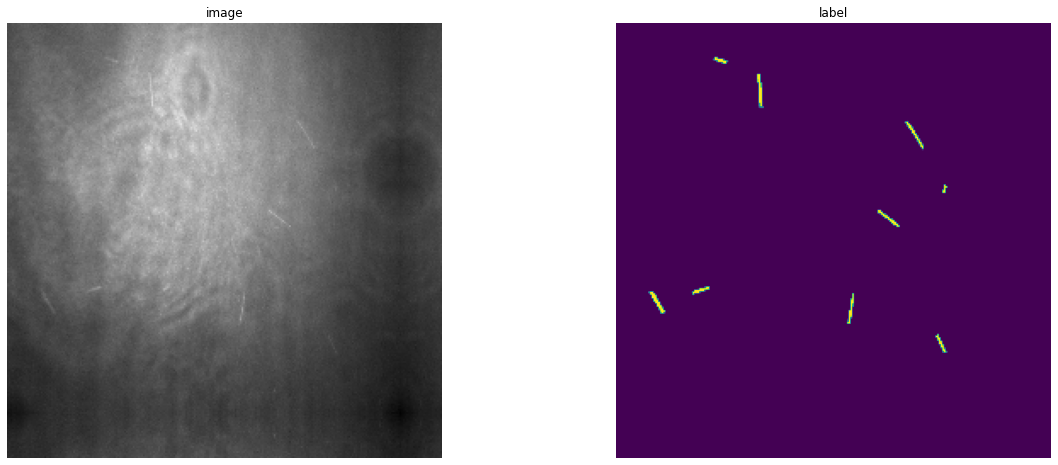

In [5]:
#Sanity check, view few mages

imgsize1 = x_train[0].shape
print(imgsize1)
imgsize2 = x_val[0].shape
print(imgsize2)
imgsize3 = y_train[0].shape
print(imgsize3)
imgsize4 = y_val[0].shape
print(imgsize4)

import random
image_number = random.randint(0, len(x_train))

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0].imshow(x_train[image_number])
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(y_train[image_number])
ax[1].set_title('label')
ax[1].axis('off')

In [6]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())


history=model.fit(x_train, 
          y_train,
          batch_size=8, 
          epochs=15,
          verbose=1,
          validation_data=(x_val, y_val))

InvalidArgumentError: assertion failed: [0] [Op:Assert] name: EagerVariableNameReuse

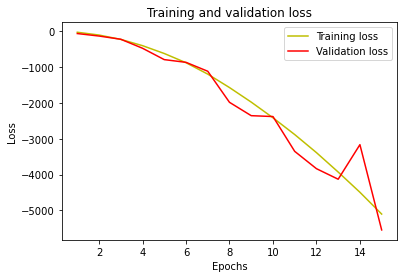

In [8]:
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("MT_256_semantic_segmantation_model.h5")

(256, 256, 3)
(256, 256)
(1200, 1200)


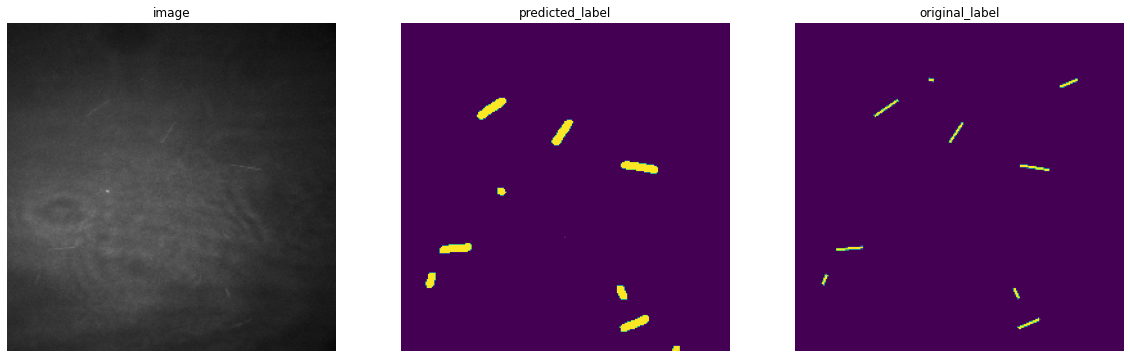

In [8]:
from tensorflow import keras
test_model = keras.models.load_model("MT_256_semantic_segmantation_model.h5", compile=False)
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('images/005_img.png', cv2.IMREAD_COLOR)
label_img = cv2.imread('labels/005_label.png',0)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
#test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_image = np.expand_dims(test_img, axis=0)

prediction = test_model.predict(test_image)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)

imgsize5 = test_img.shape
print(imgsize5)
imgsize6 = prediction_image.shape
print(imgsize6)
imgsize7 = label_img.shape
print(imgsize7)

fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

ax[0].imshow(test_img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(prediction_image)
ax[1].set_title('predicted_label')
ax[1].axis('off')

ax[2].imshow(cv2.resize(label_img, (SIZE_Y, SIZE_X)))
ax[2].set_title('original_label')
ax[2].axis('off')

plt.imsave('test_segmented.png', prediction_image, cmap='gray')

In [1]:
array_of_image = [] # this if for store all of the image data
# this function is for read image,the input is directory name
def read_image(directory_name):
    imgList = os.listdir(r"./"+directory_name)
    imgList.sort(key=lambda x: int(x.replace("200818_xb_reaction2_6um003c1t","").split('.')[0]))
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for count in range(0, len(imgList)):
        filename = imgList[count]
        #img is used to store the image data 
        img = cv2.imread(directory_name + "/" + filename, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        array_of_image.append(img) 

read_image("000_30_png")

#imgsize8 = array_of_image.shape
#print(imgsize8)

NameError: name 'cv2' is not defined

In [12]:
# center point
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

Length_Micotubulues = []

MT_model = keras.models.load_model("MT_256_semantic_segmantation_model.h5", compile=False)

for image in array_of_image:

    image = cv2.resize(image, (SIZE_Y, SIZE_X))
    image = np.expand_dims(image, axis=0)

    prediction_MT = MT_model.predict(image)

    prediction_image_MT = prediction_MT.reshape(mask.shape)

    gray = cv2.cvtColor(prediction_image_MT,cv2.COLOR_BGR2GRAY)
    # threshold
    thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

    # find objects
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    print(len(cnts))

    #creating date list for each image
    boxes = []

    tltrX_list = []
    tltrY_list = []
    blbrX_list = []
    blbrY_list = []

    tlblX_list = []
    tlblY_list = []
    trbrX_list = []
    trbrY_list = []

    dA_list = []
    dB_list = []

    #caculate the length
    for c in cnts:
        # if it's too samll, it might be noise, just ignore it
        if cv2.contourArea(c) < 30:
            continue

        orig = image.copy()
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        box = perspective.order_points(box)

        boxes.append(box.astype("int"))

        #cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

        #for (x, y) in box:
        #cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        tltrX_list.append(tltrX)
        tltrY_list.append(tltrY)
        blbrX_list.append(blbrX)
        blbrY_list.append(blbrY)

        tlblX_list.append(tlblX)
        tlblY_list.append(tlblY)
        trbrX_list.append(trbrX)
        trbrY_list.append(trbrY)

        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        dA_list.append(dA)
        dB_list.append(dB)

    #transfer data type from list to array
    tltrX_list = np.array(tltrX_list)
    tltrY_list = np.array(tltrY_list)
    blbrX_list = np.array(blbrX_list)
    blbrY_list = np.array(blbrY_list)

    tlblX_list = np.array(tlblX_list)
    tlblY_list = np.array(tlblY_list)
    trbrX_list = np.array(trbrX_list)
    trbrY_list = np.array(trbrY_list)

    #the list of length of each Microtubule in each image
    #print(len(dB_list))

    Length_Micotubulues.append(dB_list)

    img = image.copy()
    for i in range(len(tltrX_list)):
        cv2.line(img, (int(tltrX_list[i]), int(tltrY_list[i])), (int(blbrX_list[i]), int(blbrY_list[i])),(255, 0, 255), 2)
        cv2.line(img, (int(tlblX_list[i]), int(tlblY_list[i])), (int(trbrX_list[i]), int(trbrY_list[i])),(255, 0, 255), 2)
        cv2.putText(img, "{:.1f}".format(dA_list[i]), (int(tltrX_list[i] - 15), int(tltrY_list[i] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
        cv2.putText(img, "{:.1f}".format(dB_list[i]), (int(trbrX_list[i] + 10), int(trbrY_list[i])), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 255, 255), 2)
    
    plt.imshow(img)

    #cv2.imshow("Image", img[0])

    #fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

    #ax[0].imshow(img[0])
    #ax[0].set_title('image_1')
    #ax[0].axis('off')

    #ax[1].imshow(image)
    #ax[1].set_title('image_2')
    #ax[1].axis('off')


    #img_box = image.copy()
    #for k in range(len(boxes)):
        #cv2.drawContours(img_box, [boxes[k].astype("int")], -1, (0, 255, 0), 2)

    #cv2.imshow("Image_box", img_box)

    cv2.waitKey(0)

In [ ]:
#test of the last one micotubulues for every image
Case_Microtubules = []
for m in Length_Micotubulues:
    Case_Microtubules.append(m[0])

#scatter plot
x = np.array([np.arange(0,len(Length_Micotubulues))])
y = np.array([Case_Microtubules])

plt.scatter(x, y)
plt.show()

#linear regression
x_l = np.array([np.arange(0,len(Length_Micotubulues))])
y_l = Case_Microtubules

my_pwlf = pwlf.PiecewiseLinFit(x_l, y_l)
breaks = my_pwlf.fit(3)
print(breaks)

x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(x_hat, y_hat, '-')
plt.show()